# Week 1

On the first week the goal is to study the evaluation metrics needed for the system, in order also to be confortable with the data available. The metrics are:

* **Object Detection**:
 	* Mean Intersection over Union
    * Mean Average Precision

* **Optical Flow**:
    * Mean Square Error in Non-occluded areas
    * Percentage of Erroneous Pixels in Non-occluded areas

In [1]:
%load_ext autoreload
%autoreload 2

We first have used ffmpeg to save all the frames from the video using the following command: `%ffmpeg -i AICity_data/train/S03/c010/vdo.avi frames/output%03d.jpg`

## Imports

In [61]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from src.utils.readers import AnnotationReader
from src.utils.plot import visualize_random_frames
from src.utils.entities import BoundingBox
from src.utils.noise import apply_noise_to_bounding_boxes
from src.metrics.avg_precision import compute_average_precision

## Data Location

In [62]:
DATA_ROOT = Path('data')
FULL_ANNOTATION_PATH = DATA_ROOT / 'ai_challenge_s03_c010-full_annotation.xml'
AICITY_DATA_ROOT = DATA_ROOT / Path('AICity_data/train/S03/c010')
FRAMES_LOCATION = DATA_ROOT / 'frames'
RESULTS_ROOT = Path('results')
VIDEO_PATH = AICITY_DATA_ROOT / 'vdo.avi'

assert DATA_ROOT.exists()
assert FULL_ANNOTATION_PATH.exists()
assert AICITY_DATA_ROOT.exists()
assert FRAMES_LOCATION.exists()
assert RESULTS_ROOT.exists()

## Load the full xml annotation file & get the grouped by frame number

In [48]:
reader = AnnotationReader(FULL_ANNOTATION_PATH)
bounding_boxes = reader.get_bounding_boxes(classes=['car'], group_by='frame')

In [21]:
len(bounding_boxes.keys())

2141

Let's try to print some bboxes on the images

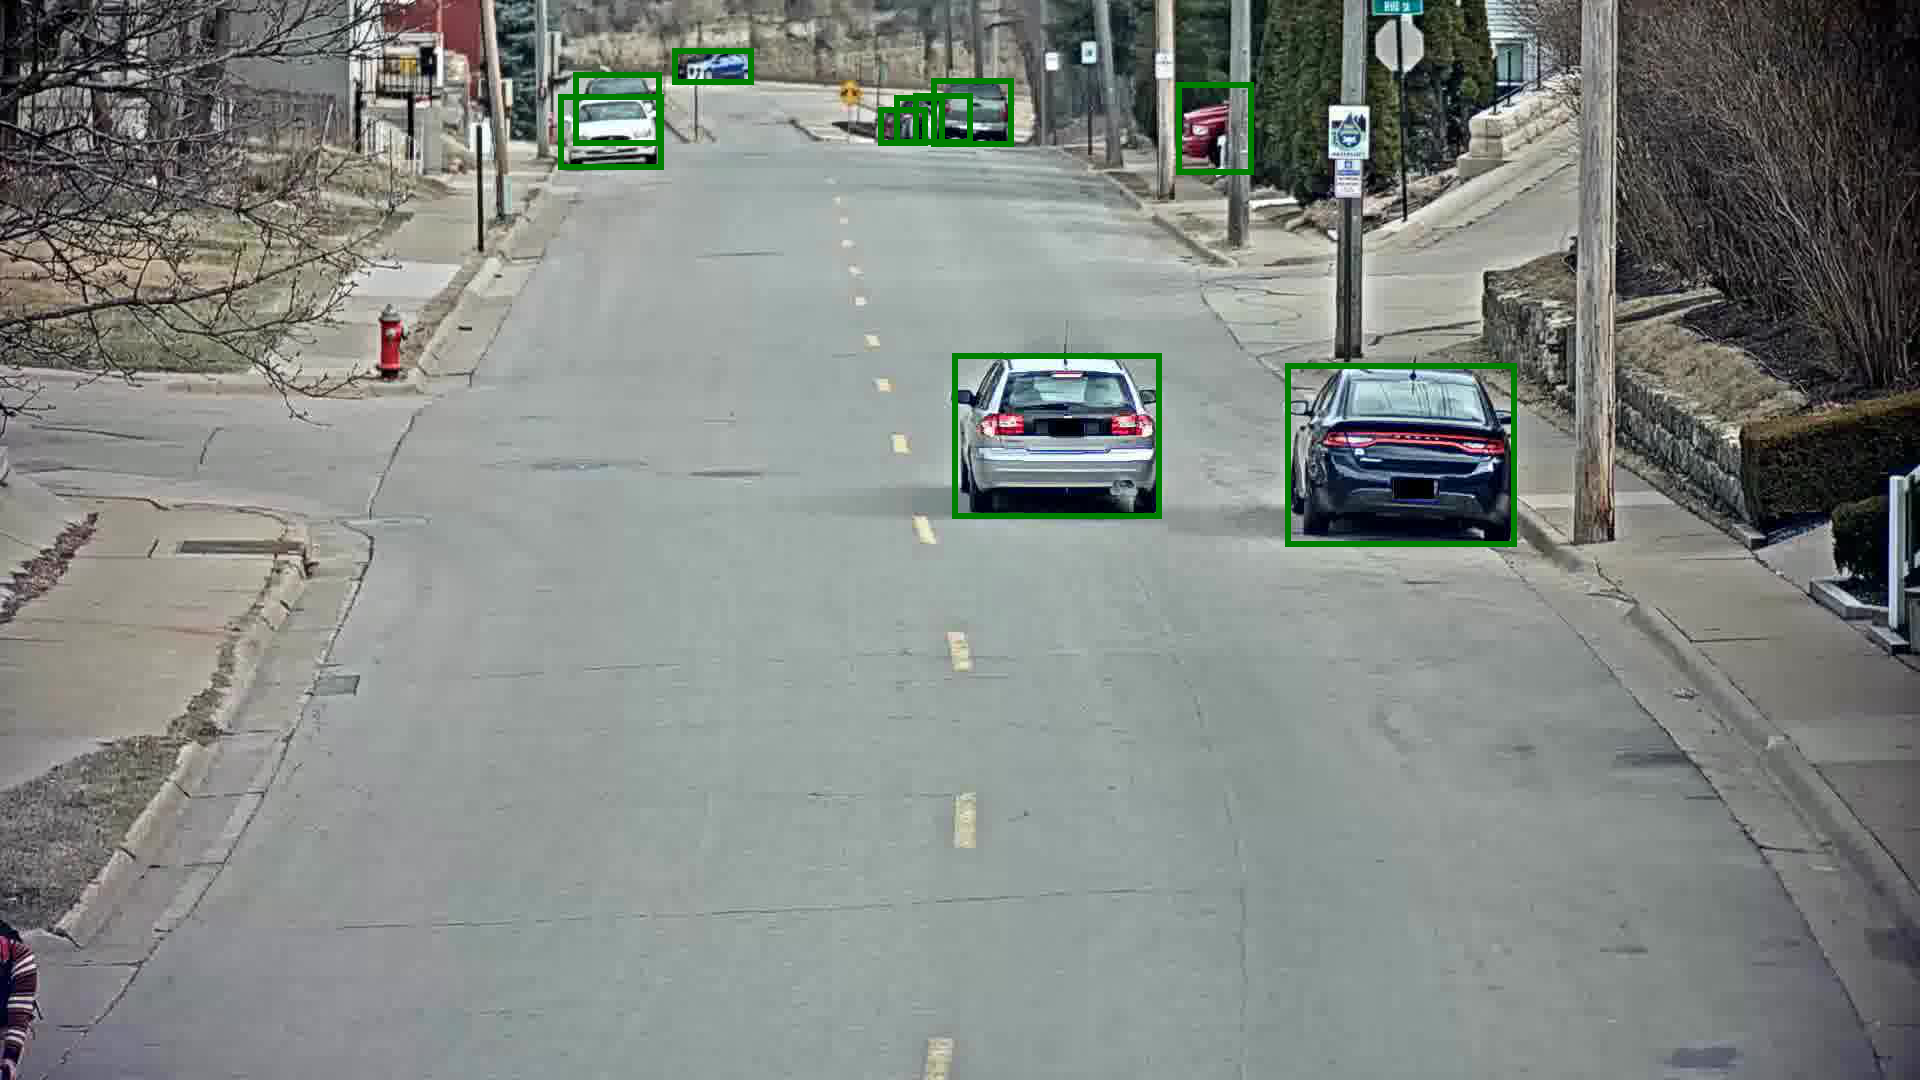

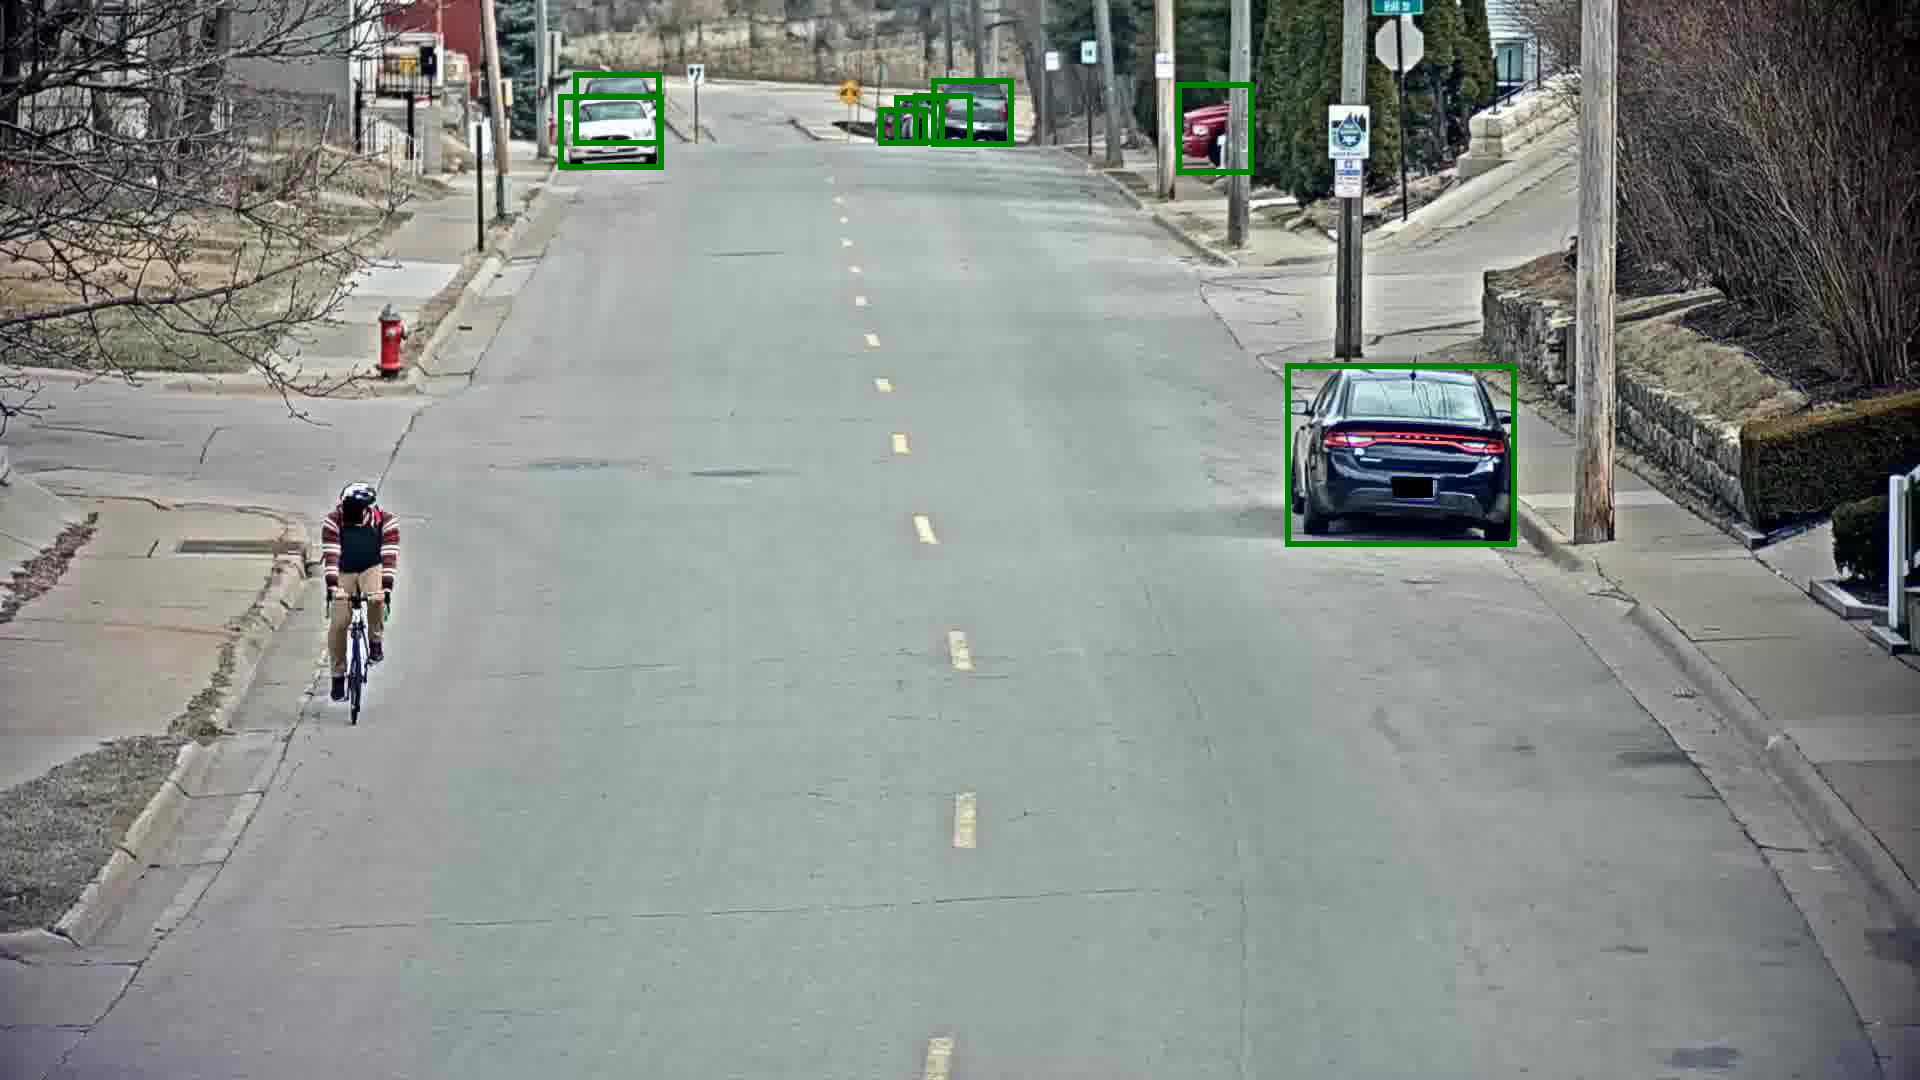

In [31]:
visualize_random_frames(FRAMES_LOCATION, bounding_boxes, frames_to_show=2)

## Add noise to the Ground-Truth and Compute the mean average precision

Now we would want to ensure that the metrics implemented are correct. To do so we use the function `apply_noise_to_bounding_boxes` to apply different effects that can occur during the prediction:

* Droping bounding boxes: where some bounding boxes dissapear
* Generating non-existing bounding_boxes: creating new bounding boxes
* Adding regular noise to the current bounding_boxes

We will do two experiments:
* Increase the droping probability
* Increase the standard deviation of the noise applied to the bounding boxes

In [58]:
gt_bounding_boxes = reader.get_bounding_boxes(classes=['car'], group_by=None)

In [ ]:
SAVE_PATH = RESULTS_ROOT / 'week1'
SAVE_PATH.mkdir(exists_ok=True)

Changing the drop probability

In [ ]:
# -- Different Drop Porbabilities -- #
steps = 15
drop_probabilities_range = np.linspace(0,1,steps)
mAP_values = []
for drop_value in drop_probabilities_range:
    noise = {'drop_probability': drop, 'mean': 0.0, 'std': 0.0}
    noisy_bounding_boxes = apply_noise_to_bounding_boxes(bounding_boxes, noise)
    mAP = compute_average_precision(0.5, gt_bounding_boxes, noisy_bounding_boxes)
    mAP_values.append(mAP)

In [ ]:
filename = 'map_vs_drop_prob.png'

# -- Plotting -- #
plt.plot(drop_probabilities_range, mAP_values)
plt.xticks(drop_probabilities_range)
plt.xlabel('drop probability')
plt.ylabel('mAP')
plt.show()
plt.savefig(SAVE_PATH / filename)

Changing the standard deviation

In [ ]:
steps = 15
std_range = np.linspace(0, 100, steps)
mAP_values = []
for std_value in std_range:
    noise = {'drop_probability': 0.0, 'mean': 0.0, 'std': std_value}
    noisy_bounding_boxes = apply_noise_to_bounding_boxes(bounding_boxes, noise)
    mAP = compute_average_precision(0.5, gt_bounding_boxes, noisy_bounding_boxes)
    mAP_values.append(mAP)

In [ ]:
filename = 'map_vs_std.png'

# -- Plotting -- #
plt.plot(std_range, mAP_values)
plt.xticks(std_range)
plt.xlabel('std')
plt.ylabel('mAP')
plt.show()
plt.savefig(SAVE_PATH / filename)

## Compute mAP for the different detectors

In [ ]:
detectors = ['mask_rcnn', 'ssd512', 'yolo3']
for detector in detectors:
    det_reader = AnnotationReader(AICITY_DATA_ROOT / f'det/det_{detector}.txt')
    predicted_bounding_boxes = reader.get_bounding_boxes(classes=['car'], group_by=None)
    mAP = compute_average_precision(0.5, gt_bounding_boxes, predicted_bounding_boxes)
    print(f'{detector} mAP: {mAP:.4f}')

## Compute mAP for a video sequence

In [ ]:
gt_bounding_boxes = reader.get_bounding_boxes(classes=['car'], group_by='frames')
noise = {'drop_probability': 0.05, 'mean': 0.0, 'std': 15}
noisy_bounding_boxes = apply_noise_to_bounding_boxes(gt_bounding_boxes, nnoise)

In [ ]:
frames = list(gt_bounding_boxes.keys())
total_iou_per_frame = []
for frame in frames:
    gt_boxes = [bb.bbox for bb in gt_bounding_boxes.get(frame)]
    pred_boxes = [bb.bbox for bb in noisy_bounding_boxes.get(frame)]
    iou_pre_frame = []
    for box1, box2 in zip(gt_boxes, pred_boxes):
        iou_per_frame.append(compute_iou(box1, box2))
    total_iou_per_frame.append(np.mean(iou_per_frame))

Create video from the total iou per frame

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
image = ax[0].imshow(np.zeros((height, width)))
line, = ax[1].plot(frames, overlaps)
artists = [image, line]

def update(i):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
    ret, img = cap.read()
    for bb in gt_bounding_boxes[frames[i]]:
        cv2.rectangle(img, (int(bb.xtl), int(bb.ytl)), (int(bb.xbr), int(bb.ybr)), (0, 255, 0), 4)
    for bb in noisy_bounding_boxes[frames[i]]:
        cv2.rectangle(img, (int(bb.xtl), int(bb.ytl)), (int(bb.xbr), int(bb.ybr)), (0, 0, 255), 4)
    artists[0].set_data(img[:, :, ::-1])
    artists[1].set_data(frames[:i + 1], total_iou_per_frame[:i + 1])
    return artists

ani = animation.FuncAnimation(fig, update, len(frames), interval=2, blit=True)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('#frame')
ax[1].set_ylabel('mean IoU')
fig.suptitle('Video Noisy Annotation')
ani.save(SAVE_PATH / 'video_iou.gif', writer='imagemagick')
plt.show()

## Optical Flow